In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
import catboost

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import time


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['cleaned_ltfs.csv']


In [2]:
data = pd.read_csv("../input/cleaned_ltfs.csv")
# data = data.drop(["SEC.DISBURSED.AMOUNT","DisbursalDate","State_ID","Employee_code_ID",
#                     "SEC.ACTIVE.ACCTS","SEC.OVERDUE.ACCTS","SEC.CURRENT.BALANCE","SEC.SANCTIONED.AMOUNT","SEC.NO.OF.ACCTS","AVERAGE.ACCT.AGE",
#                     "CREDIT.HISTORY.LENGTH","PERFORM_CNS.SCORE","branch_id","supplier_id","Current_pincode_ID","SEC.INSTAL.AMT"],axis=1)
#train = train.drop(["manufacturer_id","Employment_Type","Aadhar_flag","PAN_flag","VoterID_flag","Driving_flag","Passport_flag","PERFORM_CNS_SCORE_DESCRIPTION","loan_default"],axis=1)

In [3]:
data.head()

,Unnamed: 0,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment_Type,DisbursalDate,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,0,50578,58400,89.55,67,22807,45,1441,Salaried,03-08-18,6,1998,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,34
1,1,47145,65550,73.23,67,22807,45,1502,Self employed,26-09-18,6,1998,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1.916667,1.916667,0,1,33
2,2,53278,61360,89.63,67,22807,45,1497,Self employed,01-08-18,6,1998,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,33
3,3,57513,66113,88.48,67,22807,45,1501,Self employed,26-10-18,6,1998,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0.666667,1.250000,1,1,25
4,4,52378,60300,88.39,67,22807,45,1495,Self employed,26-09-18,6,1998,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,1,1,41


In [4]:
data = data.drop(["Unnamed: 0"],axis=1)

In [5]:
data['manufacturer_id']=data['manufacturer_id'].astype(np.object)
data['Aadhar_flag']=data['Aadhar_flag'].astype(np.object)
data['PAN_flag']=data['PAN_flag'].astype(np.object)
data['VoterID_flag']=data['VoterID_flag'].astype(np.object)
data['Driving_flag']=data['Driving_flag'].astype(np.object)
data['Aadhar_flag']=data['Aadhar_flag'].astype(np.object)
data['Passport_flag']=data['Passport_flag'].astype(np.object)
data['branch_id']=data['branch_id'].astype(np.object)
data['supplier_id']=data['supplier_id'].astype(np.object)
data['Employee_code_ID']=data['Employee_code_ID'].astype(np.object)
data['State_ID']=data['State_ID'].astype(np.object)
data['Current_pincode_ID']=data['Current_pincode_ID'].astype(np.object)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 39 columns):
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null object
supplier_id                            233154 non-null object
manufacturer_id                        233154 non-null object
Current_pincode_ID                     233154 non-null object
Employment_Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null object
Employee_code_ID                       233154 non-null object
Aadhar_flag                            233154 non-null object
PAN_flag                               233154 non-null object
VoterID_flag                           233154 non-null object
Driving_flag          

In [6]:
data['Employment_Type'].fillna('Other',inplace=True)

In [7]:
X,Y = data.drop('loan_default',axis=1),data['loan_default']
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.3,random_state = 2001)

In [ ]:
class ModelOptimizer:
    best_score = None
    opt = None
    
    def __init__(self, model, X_train, y_train, categorical_columns_indices=None, n_fold=5, seed=2001, early_stopping_rounds=30, is_stratified=True, is_shuffle=True):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.categorical_columns_indices = categorical_columns_indices
        self.n_fold = n_fold
        self.seed = seed
        self.early_stopping_rounds = early_stopping_rounds
        self.is_stratified = is_stratified
        self.is_shuffle = is_shuffle
        
        
    def update_model(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self.model, k, v)
            
    def evaluate_model(self):
        pass
    
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        start_time = time.time()
        
        @use_named_args(param_space)
        def _minimize(**params):
            self.model.set_params(**params)
            return self.evaluate_model()
        
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, n_random_starts=n_random_starts, random_state=2405, n_jobs=-1)
        best_values = opt.x
        optimal_values = dict(zip([param.name for param in param_space], best_values))
        best_score = opt.fun
        self.best_score = best_score
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'.format(optimal_values, best_score, time.time() - start_time))
        print('updating model with optimal values')
        self.update_model(**optimal_values)
        plot_convergence(opt)
        return optimal_values
    
class CatboostOptimizer(ModelOptimizer):
    def evaluate_model(self):
        validation_scores = catboost.cv(
        catboost.Pool(self.X_train, 
                      self.y_train, 
                      cat_features=self.categorical_columns_indices),
        self.model.get_params(), 
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
        verbose=100,
        plot=False)
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:, 2]
        best_metric = test_scores.max()
        return 1 - best_metric

In [8]:
categorical_features_indices = np.where(X_train.dtypes =='object')[0]
categorical_features_indices

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17])

In [ ]:
cb = catboost.CatBoostClassifier(n_estimators=4000, # use large n_estimators deliberately to make use of the early stopping
                         loss_function='Logloss',
                         eval_metric='AUC',
                         boosting_type='Plain', # use permutations
                         random_seed=1994, 
                         use_best_model=True)
cb_optimizer = CatboostOptimizer(cb, X_train, Y_train,categorical_columns_indices=categorical_features_indices)
params_space = [Real(0.01, 0.8, name='learning_rate'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
m=CatBoostClassifier(n_estimators=3000,random_state=1994,eval_metric='AUC',max_depth=6,learning_rate=0.029,od_wait=50
                     ,l2_leaf_reg=5,cat_features=categorical_features_indices,bagging_temperature=0.85,random_strength=100,
                     use_best_model=True)
m.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_val, Y_val)], early_stopping_rounds=100,verbose=100)
p2=m.predict_proba(X_val)[:,-1]


0:	test: 0.5284850	test1: 0.5261551	best: 0.5261551 (0)	total: 815ms	remaining: 40m 45s
100:	test: 0.7057390	test1: 0.6459912	best: 0.6465864 (92)	total: 58.3s	remaining: 27m 52s
200:	test: 0.7176905	test1: 0.6531911	best: 0.6534176 (196)	total: 1m 56s	remaining: 27m 3s
300:	test: 0.7221797	test1: 0.6552739	best: 0.6555783 (278)	total: 2m 56s	remaining: 26m 23s
400:	test: 0.7256704	test1: 0.6581323	best: 0.6581346 (399)	total: 3m 54s	remaining: 25m 22s
500:	test: 0.7276588	test1: 0.6622010	best: 0.6622058 (499)	total: 4m 58s	remaining: 24m 48s
600:	test: 0.7269762	test1: 0.6704250	best: 0.6704250 (600)	total: 6m 8s	remaining: 24m 31s
700:	test: 0.7287272	test1: 0.6738033	best: 0.6738033 (700)	total: 7m 21s	remaining: 24m 7s
800:	test: 0.7318694	test1: 0.6752634	best: 0.6752634 (800)	total: 8m 33s	remaining: 23m 29s
900:	test: 0.7340624	test1: 0.6761595	best: 0.6761595 (900)	total: 9m 45s	remaining: 22m 44s
1000:	test: 0.7354974	test1: 0.6767145	best: 0.6767145 (1000)	total: 10m 55s	rem

In [10]:
sorted(zip(m.feature_importances_,X_train),reverse=True)



[(11.97048476982719, 'ltv'),
 (7.304955077323785, 'Employee_code_ID'),
 (5.860913827931887, 'disbursed_amount'),
 (5.508679762189029, 'branch_id'),
 (5.3238495408094035, 'supplier_id'),
 (5.0849912735863905, 'PERFORM_CNS_SCORE_DESCRIPTION'),
 (4.908524649051178, 'Current_pincode_ID'),
 (4.823766156931613, 'DisbursalDate'),
 (4.149026631366094, 'State_ID'),
 (4.126227772543484, 'PERFORM_CNS.SCORE'),
 (4.053302978354182, 'Age'),
 (3.9747246936173437, 'Employment_Type'),
 (3.2115251644328286, 'PRIMARY.INSTAL.AMT'),
 (3.154378959282058, 'manufacturer_id'),
 (2.82002811396867, 'asset_cost'),
 (2.539341701000321, 'CREDIT.HISTORY.LENGTH'),
 (2.4791515599849174, 'NO.OF_INQUIRIES'),
 (2.3724990796625156, 'PRI.NO.OF.ACCTS'),
 (2.2565571170093723, 'PRI.CURRENT.BALANCE'),
 (2.2182453001689284, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'),
 (1.9874709881448362, 'AVERAGE.ACCT.AGE'),
 (1.9743426681929679, 'PRI.OVERDUE.ACCTS'),
 (1.6771617218110308, 'PRI.DISBURSED.AMOUNT'),
 (1.6047886685838741, 'PRI.SANCTI

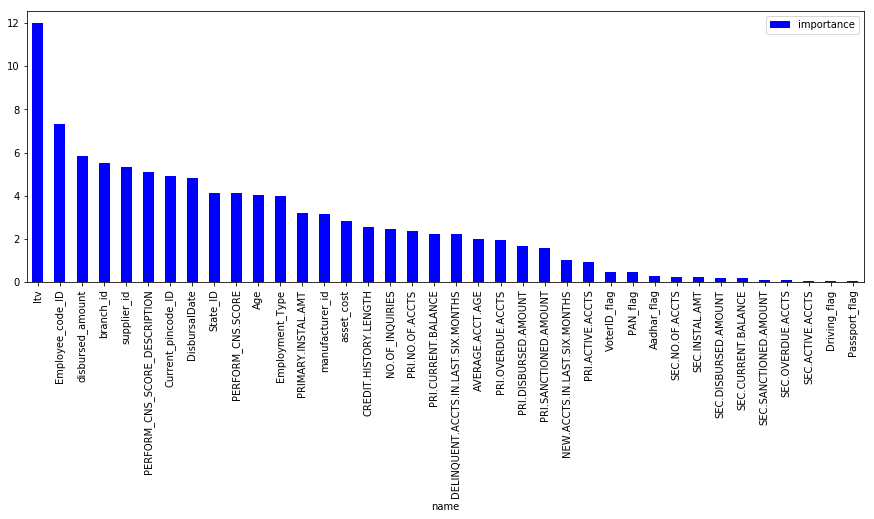

In [11]:
feature = pd.DataFrame()
X_train = pd.DataFrame(X_train)

feature['name'] = X_train.columns
feature['importance'] = m.feature_importances_

feature.sort_values(by = ['importance'], ascending = False, inplace = True)
feature.set_index('name', inplace = True)

feature.plot(kind = 'bar', color = 'blue', figsize = (15, 5), fontsize = 10)
